# Tests

In [1]:
import simplem_par as simplem
import matplotlib.pyplot as plt
import richdem
import numpy as np
%load_ext autoreload
%autoreload 2

## Test sinkfill on initially flat grid

In [2]:
model = simplem.simple_model()
Zi = model.Z.copy()

In [3]:
model.sinkfill()

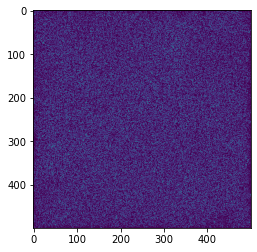

In [4]:
plt.imshow(model.Z-Zi)

In [5]:
assert(np.all(model.Z-Zi>=0)) ## Assert that we are filling every cell

## Compare filling results to richdem

In [6]:
Z = richdem.rdarray(Zi,no_data=0)
Z_rich = richdem.ResolveFlats(richdem.FillDepressions(Z))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 0.0234625 s

A Barnes (2014) Flat Resolution Flat Mask Generation
C Barnes, R., Lehman, C., Mulla, D., 2014a. An efficient assignment of drainage direction over flat surfaces in raster digital elevation models. Computers & Geosciences 62, 128–135. doi:10.1016/j.cageo.2013.01.009

t Succeeded in = 0.00231775 s
p Setting up labels matrix...
p Setting up flat resolution mask...
p Searching for flats...
t Succeeded in = 0.00650612 s=================] (100% - 0.0s - 1 threads)=====================                    ] (60% - 0.0s - 1 threads)
m Cells with no flow direction = 97524
m Low edge cells               = 4787
m High edge cells              = 97463
p Labeling flats...
m Unique flats =

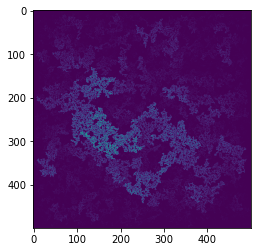

In [7]:
plt.imshow(np.abs(Z_rich - model.Z),vmin=0,vmax=.001) #should be extremely minor differences

In [8]:
assert((np.sum(np.abs((Z_rich-Zi) - (model.Z-Zi))/np.sum(np.abs(model.Z-Zi)))<1e-3)) # We want there to be less than 0.1% difference in the volume filled

## Flowacc

In [9]:
model.set_z(Z_rich)
model.slp()
model.stack()
model.acc()

0


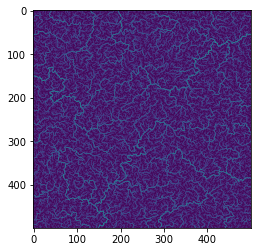

In [10]:
plt.imshow(np.log(model.A))

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 0.0230735 s

A Barnes (2014) Flat Resolution Flat Mask Generation
C Barnes, R., Lehman, C., Mulla, D., 2014a. An efficient assignment of drainage direction over flat surfaces in raster digital elevation models. Computers & Geosciences 62, 128–135. doi:10.1016/j.cageo.2013.01.009

t Succeeded in = 0.00278271 s
p Setting up labels matrix...
p Setting up flat resolution mask...
p Searching for flats...
t Succeeded in = 0.00664475 s=================] (100% - 0.0s - 1 threads)
m Cells with no flow direction = 97524
m Low edge cells               = 4787
m High edge cells              = 97463
p Labeling flats...
m Unique flats = 4788
p Removing flats without outlets from the queue...
  The flat

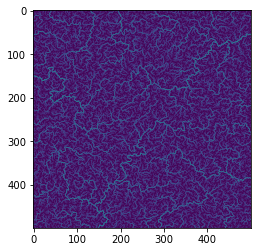

In [11]:
A = richdem.FlowAccumulation(richdem.ResolveFlats(richdem.FillDepressions(Z)),method='D8')
plt.imshow(np.log(A)) 

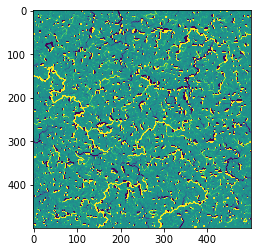

In [12]:
plt.imshow(model.A - A,vmin=-10,vmax=10) #Difference appears to be due to how flats are resolved - that said, there is not much difference in the totals

In [13]:
assert((np.max(model.A)-np.max(A))/np.max(A)<.01)#Want to make sure there is less than 1% difference in the drainage area of the largest basin

## Compare to landlab

In [14]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, FastscapeEroder,LinearDiffuser
import numpy as np

In [15]:
Zi = np.random.rand(20, 20)+.01

In [16]:
mg = RasterModelGrid((20, 20), xy_spacing=(1.0, 5.0))
Zi2 = Zi.copy()

Zi2 = mg.add_field("topographic__elevation", Zi2, at="node")
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
fa = FlowAccumulator(
     mg,
     'topographic__elevation',
     flow_director='FlowDirectorD8'
     )
fa.run_one_step()
A0 = mg.at_node['drainage_area']
sp = FastscapeEroder(mg, K_sp=1e-6, n_sp = 1)
sp.run_one_step(dt=10)

In [17]:
model = simplem.simple_model()
model.set_z(Zi.copy())
model.dt = 10
model.dx = 1
model.dy = 5
model.BCX = np.zeros((20,20),dtype=np.int64)
model.BCX[:, 0] = 1
model.BCX[:, -1] = 1
model.BCX[0, :] = 1
model.BCX[-1, :] = 1
model.BC = np.where(model.BCX == 1)[0]
#model.BC= np.zeros(0,dtype=np.int64)
model.k = np.zeros(np.shape(model.Z))+1e-6
model.slp_basin()
model.stack()
model.acc()
model.erode()

38


In [18]:
E1 = -model.Z + Zi.reshape(20,20)
E2 = -Zi2.reshape(20,20) + Zi.reshape(20,20)

In [19]:
assert(np.all(np.abs(E1-E2)<1e-8)) #Should be near zero everywhere

In [20]:
E = simplem.erode_explicit(model.slps, model.I, model.s, model.A, np.zeros(np.shape(model.slps)), dx=1, dy=5.00, m=0.5, n=1.0, k=np.zeros(np.shape(model.Z))+1e-6, dt=10, carea=0, G=0);

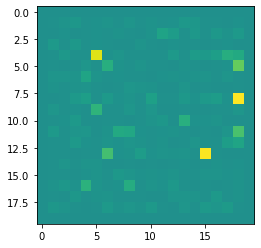

In [21]:
plt.imshow((E-E1)/(E1+.00000001),vmin=-.01,vmax=.01) #Should be some minor differences (but mostly zeros)

## Compare Diffusion

In [22]:
mg = RasterModelGrid(np.shape(Zi), xy_spacing=(1.0, 1.0))
Zi2 = mg.add_field("topographic__elevation", Zi.copy(), at="node")
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
ld = LinearDiffuser(mg, linear_diffusivity=1e-3, method='simple', deposit= True)
ld.run_one_step(dt=10)

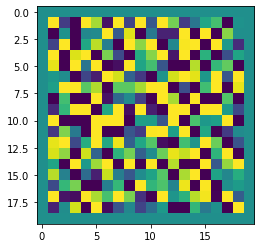

In [23]:
E2 = -Zi2.reshape(20,20) + Zi.reshape(20,20)
plt.imshow(E2, vmin=-.01, vmax=.01)

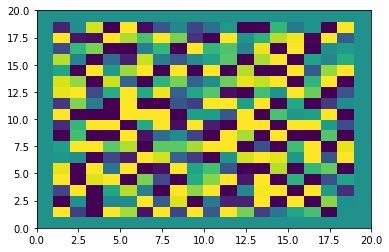

In [24]:
E = simplem.diffuse(Zi.copy(),D=1e-3, dy=1, dx=1, dt=10)
plt.pcolor(E, vmin=-1e-2, vmax=1e-2)


In [25]:
np.sum(E[E>0])

1.5760976042259873

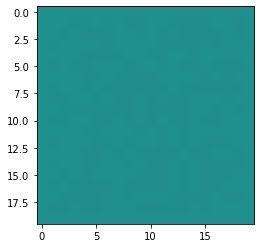

In [26]:
plt.imshow((E2-E)/(E+1e-9),vmin=-.1,vmax=.1) # SHould be the same

In [27]:
assert(np.linalg.norm(E2-E)<1e-5)

## Test the cosmo predict implementation - flow routing downstream

In [28]:
10**3*90**2/1e6

8.1

In [130]:
import multiprocess as mp
import matplotlib.pyplot as plt
import rasterio
import sys
#sys.path.insert(1, '/Users/gr_1/Documents/simplem/') #modify based on where it is
import simplem_par as simplem
import numpy as np
import ast
from os.path import exists

################ -------Params-------- ##################################
dem_folder = '/Users/gr_1/Google Drive_1/data_earth_engine/basins_v3/'
outfolder = '/Users/gr_1/Documents/cosmo_predict/results/' 
# Number of processors
n_proc = 1
# Number of simulations (parameter sets)
nr = 10
## Stream power parameters
#Stream power m/n (theta)
theta = 0.45
# Vector of n values.  Currently n ranges from 0-4
ns = np.random.rand(nr) * 4.0*0+2.5
# The ratio D/k. Currently the prior distribution is log-uniform from 0 to 10 km2
diffus =  np.power(10.0, np.random.rand(nr) * 12 + 1)*1e-11
#A_crit values range as a log-uniform distribution
careas = np.power(10.0, np.random.rand(nr) * 3)
# diffusion exponents (p)
ps = np.zeros(nr) + 1.0 
########################################################################


n_basin = 4631  # number of basins in octopus
ms = ns * theta # Vector of m values.  m depends on n

#The erosion rates for each basin, to contain a vector of avg erosion rates
eros1 = [None] * n_basin
#vector of avg slopes in each basin, to compare to octopus slopes
slpsall = np.zeros(n_basin)


def par_ero(i):
    """
    Parallel erosion routine for each DEM basin
    
    :param i: basin number
    :returns: A; accumulated erosion
    """
    
    #First run diffusion - we raise the coefficient by 1/p and then raise the whole
    #diffusion rate by p in order to
    E = simplem.diffuse(
        Zi, D=diffus[i]**(1.0 / ps[i]), dy=dy1, dx=dx1, dt=1)
    E[E < 0] = 0
    #We only want the erosion part....
    E = E**ps[i]
    #Raise too p
    m = ms[i]
    n = ns[i]
    #Now add the hillslope erosion and the fluvial erosion
    ero = simplem.erode_explicit(
        slps,
        I1,
        s1,
        A1,
        E,
        dx=dx1,
        dy=dy1,
        m=ms[i],
        n=ns[i],
        k=np.zeros(np.shape(slps))+1e-8,
        carea=careas[i])
    
    #This should be zero anyways but just in case...
    ero[slps == 0] = 0
    #Sum erosion downstream = we do it this way so that nodes draining outside of the basin (i.e. on the edge) are not included
    A = simplem.acc(I1, s1, init=ero.copy())
    #Calculate the avg erosion per drainage area...
    pl = (A.ravel()[np.argmax(A1.ravel())]) / np.max(A1.ravel())
    return pl, i, ero


for c in range(1500,1501):
    demfile = dem_folder + 'hydrosheds_bas_v3_{}.tif'.format(str(c))
    if exists(demfile):
        dem = rasterio.open(demfile)
        lat = dem.xy(0, 0)[1]
        
        dx = np.cos(lat / 180 * np.pi) * (1852 / 60) * \
            3  # dx is dependent on latitude
        f = simplem.simple_model()
        f.dx = dx
        f.dy = 92.59
        
        # We must pad the DEM in order to prevent edge effects
        demz=np.float64(np.squeeze(dem.read()))
        if demz.size <16:
            continue
        f.set_z(np.pad(demz, pad_width=2))
        
        #Outlet nodes are at or below 0
        f.BC = np.where(f.Z.transpose().ravel() <= 0)[0]
        
        #Fill local sinks
        f.sinkfill()
        
        #calculate local slopes and populate the receiver grid
        f.slp_basin()
        
        #Build the Fastscape stack
        f.stack()
        
        #calculate the receiver grid
        f.acc()
        
        #Get Elevation, corrected
        Zi = f.Z.copy()
        
        #Get drainage area
        A1 = f.A.copy()
        
        #Initialize mean erosion rate (per basin) vector
        mnmat = np.zeros((len(ms), 1))
        
        
        A1 = f.A.copy()
        ny1 = f.ny
        nx1 = f.nx
        I1 = f.I.copy()
        s1 = f.s.copy()
        dy1 = f.dy
        slps = f.slps
        dx1 = dx
        with mp.Pool(n_proc) as procs:
            vals = procs.map(par_ero, np.arange(len(ns)))
        #par_ero(1)
        eros1[c] = mnmat[list(zip(*vals))[1], 0] = list(zip(*vals))[0]
        f.acc(slps)
        slpsall[c] = (f.A.ravel()[f.Z.ravel() > 0][np.argmax(
            A1.ravel()[f.Z.ravel() > 0])]) / np.max(A1.ravel()[f.Z.ravel() > 0])

if 1:
    np.save('{}/eros'.format(outfolder),eros1)
    np.save('{}/diffu'.format(outfolder),diffus)
    np.save('{}/ms'.format(outfolder),ms)
    np.save('{}/ns'.format(outfolder),ns)
    np.save('{}/careas'.format(outfolder),careas)
    np.save('{}/slps2'.format(outfolder),slpsall)
    np.save('{}/dns'.format(outfolder),ps)


15618


/var/folders/7n/93rhcbnx487ddwp5twsbv8c80000gn/T/ipykernel_8614/4123778420.py:1: RuntimeWarning: divide by zero encountered in log
  plt.pcolor(np.log(vals[0][2]),vmin=-20,vmax=0)


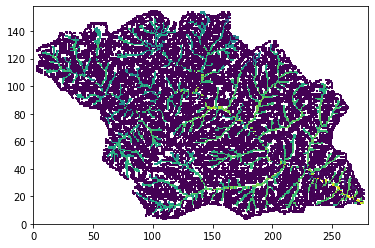

In [131]:
plt.pcolor(np.log(vals[0][2]),vmin=-20,vmax=0)

In [132]:
assert((np.sum(vals[0][2])/np.max(A1) - vals[0][0])/vals[0][0]<1e-3) #make sure the calculation of avg erosion rate works w/in the basin...